In [239]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import dateutil
from dateutil.relativedelta import relativedelta
from scipy.interpolate import interp1d
%matplotlib inline

# Import Datasets and Create Date Column

In [331]:
data_tables = ['bidding results.xlsx',
               'bidding results.csv',
              'gdp.xlsx',
              'population.xlsx',
              'unemployment.xlsx']

file_path = '/Users/smu/Desktop/Data Science stuff/COE dereg/New set/Data sets/'
cat_b_dereg = pd.read_excel(file_path + data_tables[0])
bidding_results_df = pd.read_csv(file_path + data_tables[1],sep=';')
gdp_df = pd.read_excel(file_path + data_tables[2])
population_df = pd.read_excel(file_path + data_tables[3])
unemployment_df = pd.read_excel(file_path + data_tables[4])

# Building an ARIMA Model

In [332]:
cat_b_dereg['Date'] = pd.to_datetime(cat_b_dereg['Variables'], format = '%Y %b')

In [327]:
deregistration_ts = cat_b_dereg[['Date','Cat B']]

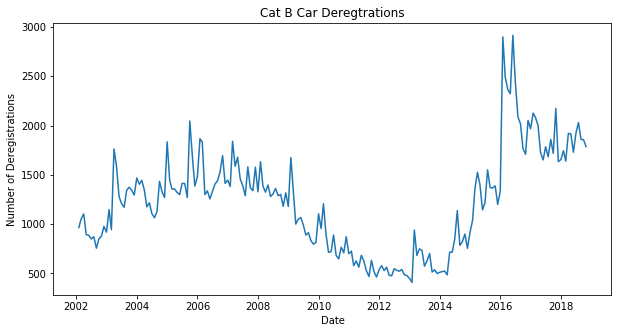

In [5]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.title('Cat B Car Deregtrations')
plt.xlabel('Date')
plt.ylabel('Number of Deregistrations')
plt.plot(deregistration_ts['Date'],deregistration_ts['Cat B'])
plt.show()

/Users/smu/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


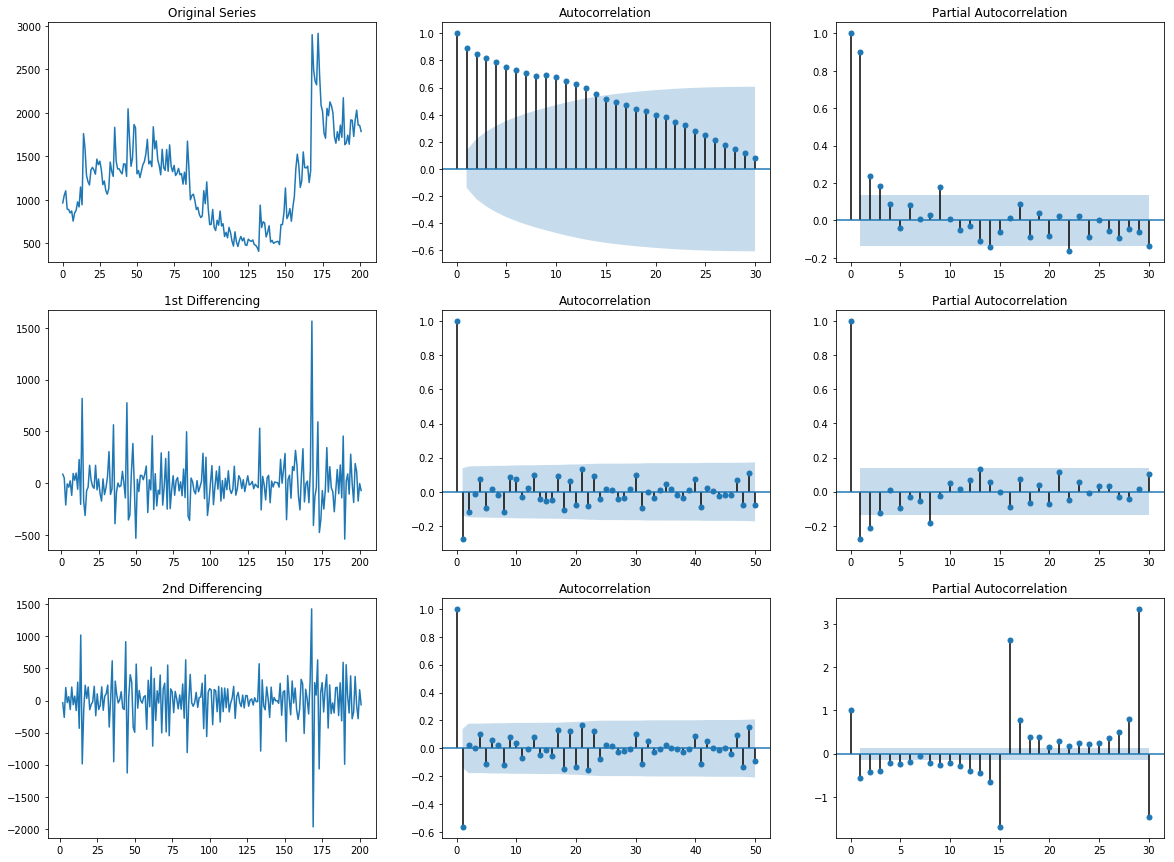

In [43]:
plt.rcParams['figure.figsize'] = (20, 15)
fig, axes = plt.subplots(3,3)

axes[0,0].plot(deregistration_ts['Cat B']); axes[0,0].set_title('Original Series')
plot_acf(deregistration_ts['Cat B'],lags=30,ax=axes[0,1])
plot_pacf(deregistration_ts['Cat B'],lags=30,ax=axes[0,2])

first_diff = deregistration_ts['Cat B'].diff()
axes[1,0].plot(first_diff); axes[1,0].set_title('1st Differencing')
plot_acf(first_diff.dropna(),lags=50,ax=axes[1,1])
plot_pacf(first_diff.dropna(),lags=30,ax=axes[1,2])

second_diff = deregistration_ts['Cat B'].diff().diff()
axes[2,0].plot(second_diff); axes[2,0].set_title('2nd Differencing')
plot_acf(second_diff.dropna(),lags=50,ax=axes[2,1])
plot_pacf(second_diff.dropna(),lags=30,ax=axes[2,2])

plt.show()

In [38]:
adfTest = adfuller(deregistration_ts['Cat B'],autolag='AIC')
adfTest_firstdiff = adfuller(first_diff.dropna(),autolag='AIC')
adfTest_seconddiff = adfuller(second_diff.dropna(),autolag='AIC')

pd.DataFrame({'original':adfTest[0:4],'firstdiff':adfTest_firstdiff[0:4],'seconddiff':adfTest_seconddiff[0:4]},index=['ADF Test Stat','P-Val','#lags used','#obs used'])

,original,firstdiff,seconddiff
ADF Test Stat,-1.633961,-1.108036e+01,-8.731528e+00
P-Val,0.465418,4.326848e-20,3.182008e-14
#lags used,3.000000,2.000000e+00,1.200000e+01
#obs used,198.000000,1.980000e+02,1.870000e+02


## Upon looking at the plots as well as the DF test, P = 5/6, D = 1, Q = 2
### Lets split into train and test sets

In [54]:
train_ts = deregistration_ts[deregistration_ts['Date'] < max(deregistration_ts['Date']) - relativedelta(years=+1)]
test_ts = deregistration_ts[deregistration_ts['Date'] >= max(deregistration_ts['Date']) - relativedelta(years=+1)]

[(189, 2), (13, 2)]

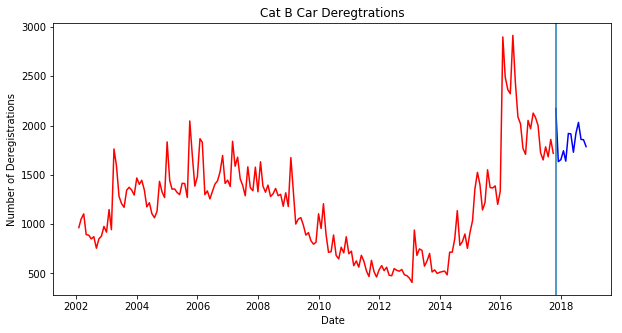

In [62]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.title('Cat B Car Deregtrations')
plt.xlabel('Date')
plt.ylabel('Number of Deregistrations')
plt.plot(train_ts['Date'],train_ts['Cat B'],'r')
plt.plot(test_ts['Date'],test_ts['Cat B'],'b')
plt.axvline(x=max(deregistration_ts['Date']) - relativedelta(years=+1))
plt.show()

In [131]:
model_arima = ARIMA(train_ts['Cat B'],order = (3,2,1))
model_arima_fitted = model_arima.fit()
model_arima_fitted.aic

2559.7790778086387

In [122]:
p = 0
d = 0
q = 0

final_aic = 1000000
final_arima_order = [0,0,0]

for p in range(0,7):
    for d in range(0,5):
        for q in range(0,7):
            try:
                tempaic = ARIMA(train_ts['Cat B'],order = (p,d,q)).fit().aic

                if (tempaic < final_aic):
                    final_aic = tempaic
                    final_arima_order = [p,d,q]
                    model_arima = ARIMA(train_ts['Cat B'], order = (p,d,q))
                    model_arima_fitted = model_arima.fit()
            except:
                pass
            
print(model_arima_fitted.summary())

/Users/smu/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/smu/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/smu/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

In [132]:
print(model_arima.fit().summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Cat B   No. Observations:                  187
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -1273.890
Method:                       css-mle   S.D. of innovations            216.150
Date:                Sat, 23 Mar 2019   AIC                           2559.779
Time:                        16:36:57   BIC                           2579.166
Sample:                             2   HQIC                          2567.635
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0661      0.173      0.382      0.703      -0.273       0.406
ar.L1.D2.Cat B    -0.3326      0.073     -4.579      0.000      -0.475      -0.190
ar.L2.D2.Cat B    -0.2419      0.074

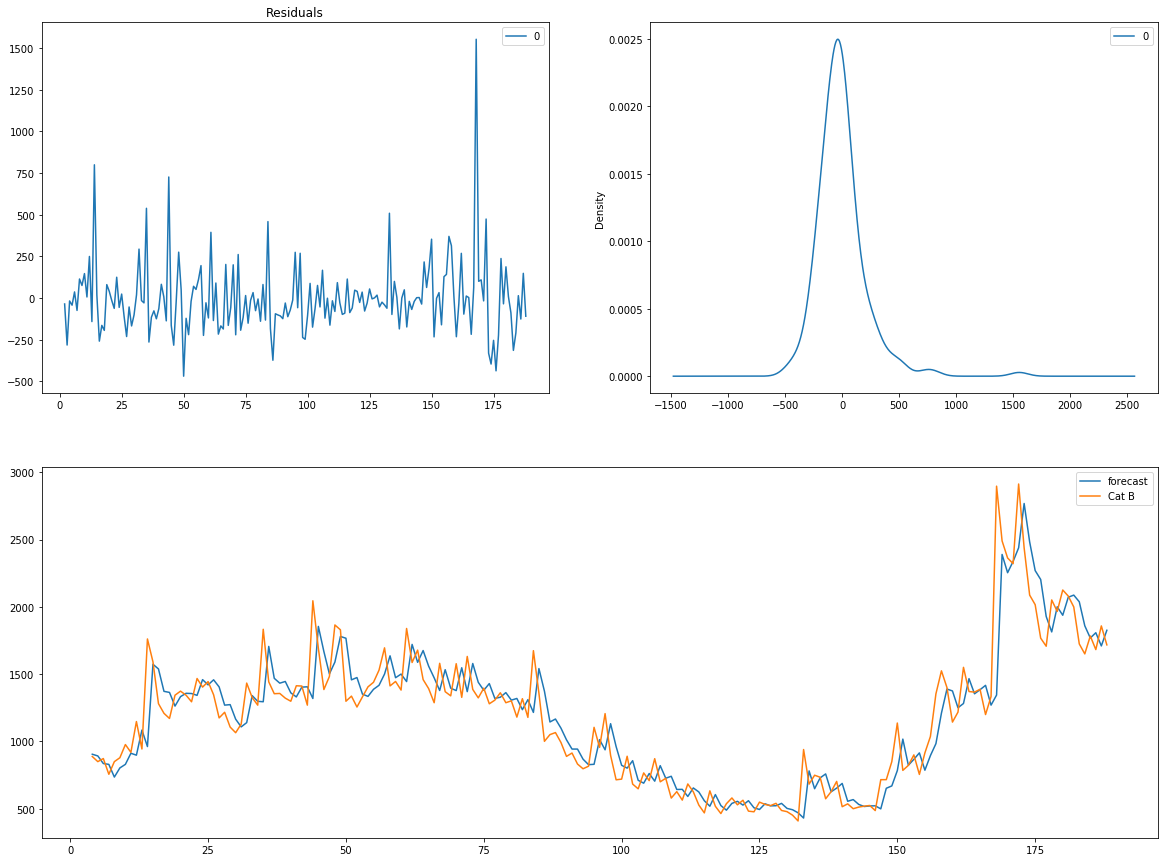

In [143]:
residuals_arima = pd.DataFrame(model_arima_fitted.resid)

plt.rcParams['figure.figsize'] = (20,15)
fig, axes = plt.subplots(2,2)
residuals_arima.plot(title = "Residuals",ax = axes[0,0])
residuals_arima.plot(kind = 'kde',ax=axes[0,1])

bottom_lower_axes = plt.subplot2grid((2,2),(1,0),colspan=2,rowspan=1)
model_arima_fitted.plot_predict(dynamic = False,ax = bottom_lower_axes)

plt.show()

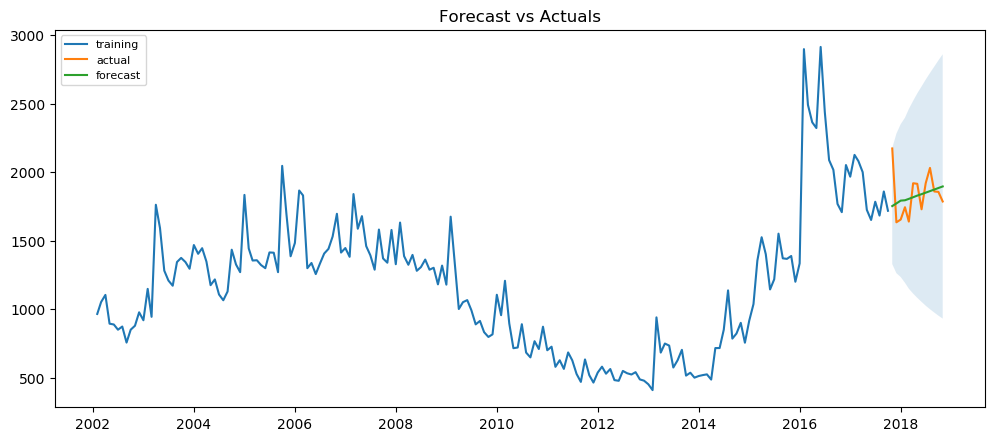

In [189]:
# Forecast
fc, se, conf = model_arima_fitted.forecast(len(test_ts['Date']),alpha=0.05)

# Pandas series
fc = pd.Series(fc,index = test_ts['Date'])
lower_series = pd.Series(conf[:,0],index = test_ts['Date'])
upper_series = pd.Series(conf[:,1],index = test_ts['Date'])

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_ts['Date'],train_ts['Cat B'], label='training')
plt.plot(test_ts['Date'],test_ts['Cat B'], label='actual')
plt.plot(test_ts['Date'],fc, label='forecast')
plt.fill_between(lower_series.index,lower_series,upper_series,alpha = 0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.show()


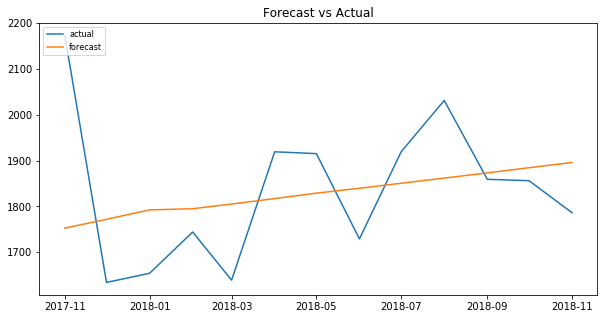

In [190]:
plt.figure(figsize = (10,5))
plt.plot(test_ts['Date'],test_ts['Cat B'], label='actual')
plt.plot(test_ts['Date'],fc, label='forecast')
plt.title('Forecast vs Actual')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [183]:
MAPE = np.mean(np.abs(fc.reset_index(drop=True) - test_ts['Cat B'].reset_index(drop=True))/np.abs(test_ts['Cat B'].reset_index(drop=True)))
MAPE

0.06593833646245044

# Random Forest

## Recall that we had GDP, Unemp, and Population datasets above

In [333]:
gdp_df['Gross Domestic Product At Current Market Prices'] = gdp_df['Gross Domestic Product At Current Market Prices']*100000
gdp_df['Quarter'] = gdp_df['Variables'].str.strip().str[-2:-1]
gdp_df['Year'] = gdp_df['Variables'].str.strip().str[0:4]
gdp_df['Month'] = gdp_df['Quarter'].astype('int64')*3
gdp_df['Date'] = gdp_df['Year'].astype('int64')*10000 + gdp_df['Month']*100 + 1
gdp_df['Date'] = pd.to_datetime(gdp_df['Date'],format='%Y%m%d')
gdp_df = gdp_df[['Date','Gross Domestic Product At Current Market Prices']]
gdp_df = gdp_df.rename(columns= {'Gross Domestic Product At Current Market Prices':'GDP'})

unemployment_df['Quarter'] = unemployment_df['Variables'].str.strip().str[-2:-1]
unemployment_df['Year'] = unemployment_df['Variables'].str.strip().str[0:4]
unemployment_df['Month'] = unemployment_df['Quarter'].astype('int64')*3
unemployment_df['Date'] = unemployment_df['Year'].astype('int64')*10000 + unemployment_df['Month']*100 + 1
unemployment_df['Date'] = pd.to_datetime(unemployment_df['Date'],format='%Y%m%d')
unemployment_df = unemployment_df[['Date','Total Unemployment Rate']]
unemployment_df = unemployment_df.rename(columns= {'Total Unemployment Rate':'unemp'})

population_df['Date'] = population_df['Variables'].astype('int64')*10000 + 1200 + 1
population_df['Date'] = pd.to_datetime(population_df['Date'],format='%Y%m%d')
population_df = population_df[['Date','Total Population']]
population_df = population_df.rename(columns= {'Total Population':'pop'})

bidding_results_df['Date'] = pd.to_datetime(bidding_results_df['Variables'], format = '%Y %b')
bidding_results_df = bidding_results_df[['Date','bid_round1','bid_round2']]

In [334]:
gdp_spline = gdp_df.set_index('Date').resample('MS').mean().interpolate(method = 'linear')
unemployment_spline = unemployment_df.set_index('Date').resample('MS').mean().interpolate(method = 'linear')
population_spline = population_df.set_index('Date').resample('MS').mean().interpolate(method = 'linear')
bidding_results_df = bidding_results_df.set_index('Date')

In [355]:
rf_df = cat_b_dereg.set_index('Date').join(gdp_spline)
rf_df = rf_df.join(unemployment_spline).join(population_spline).join(bidding_results_df)
rf_df = rf_df[['Cat B','GDP','unemp','pop','bid_round1','bid_round2']]

In [356]:
rf_df['gdp_lag1'] = rf_df['GDP'].shift(1)
rf_df['gdp_lag2'] = rf_df['GDP'].shift(2)
rf_df['gdp_lag3'] = rf_df['GDP'].shift(3)
rf_df['gdp_lag4'] = rf_df['GDP'].shift(4)
rf_df['gdp_lag5'] = rf_df['GDP'].shift(5)
rf_df['gdp_lag6'] = rf_df['GDP'].shift(6)
rf_df['gdp_lag7'] = rf_df['GDP'].shift(7)
rf_df['gdp_lag8'] = rf_df['GDP'].shift(8)
rf_df['gdp_lag9'] = rf_df['GDP'].shift(9)
rf_df['gdp_lag10'] = rf_df['GDP'].shift(10)

rf_df['unemp_lag1'] = rf_df['unemp'].shift(1)
rf_df['unemp_lag2'] = rf_df['unemp'].shift(2)
rf_df['unemp_lag3'] = rf_df['unemp'].shift(3)
rf_df['unemp_lag4'] = rf_df['unemp'].shift(4)
rf_df['unemp_lag5'] = rf_df['unemp'].shift(5)
rf_df['unemp_lag6'] = rf_df['unemp'].shift(6)
rf_df['unemp_lag7'] = rf_df['unemp'].shift(7)
rf_df['unemp_lag8'] = rf_df['unemp'].shift(8)
rf_df['unemp_lag9'] = rf_df['unemp'].shift(9)
rf_df['unemp_lag10'] = rf_df['unemp'].shift(10)

rf_df['pop_lag1'] = rf_df['pop'].shift(1)
rf_df['pop_lag2'] = rf_df['pop'].shift(2)
rf_df['pop_lag3'] = rf_df['pop'].shift(3)
rf_df['pop_lag4'] = rf_df['pop'].shift(4)
rf_df['pop_lag5'] = rf_df['pop'].shift(5)
rf_df['pop_lag6'] = rf_df['pop'].shift(6)
rf_df['pop_lag7'] = rf_df['pop'].shift(7)
rf_df['pop_lag8'] = rf_df['pop'].shift(8)
rf_df['pop_lag9'] = rf_df['pop'].shift(9)
rf_df['pop_lag10'] = rf_df['pop'].shift(10)

rf_df['bid_round1_lag1'] = rf_df['bid_round1'].shift(1)
rf_df['bid_round1_lag2'] = rf_df['bid_round1'].shift(2)
rf_df['bid_round1_lag3'] = rf_df['bid_round1'].shift(3)
rf_df['bid_round1_lag4'] = rf_df['bid_round1'].shift(4)
rf_df['bid_round1_lag5'] = rf_df['bid_round1'].shift(5)

rf_df['bid_round2_lag1'] = rf_df['bid_round2'].shift(1)
rf_df['bid_round2_lag2'] = rf_df['bid_round2'].shift(2)
rf_df['bid_round2_lag3'] = rf_df['bid_round2'].shift(3)
rf_df['bid_round2_lag4'] = rf_df['bid_round2'].shift(4)
rf_df['bid_round2_lag5'] = rf_df['bid_round2'].shift(5)

rf_df = rf_df.dropna()

In [357]:
rf_df = rf_df.reset_index()
train_rf = rf_df[rf_df['Date'] < max(rf_df['Date']) - relativedelta(years=+1)]
test_rf = rf_df[rf_df['Date'] >= max(rf_df['Date']) - relativedelta(years=+1)]

,Date,Cat B,GDP,unemp,pop,bid_round1,bid_round2,gdp_lag1,gdp_lag2,gdp_lag3,...,bid_round1_lag1,bid_round1_lag2,bid_round1_lag3,bid_round1_lag4,bid_round1_lag5,bid_round2_lag1,bid_round2_lag2,bid_round2_lag3,bid_round2_lag4,bid_round2_lag5
0,2002-12-01,977,4.211670e+09,3.900000,4.175950e+06,822,977,4.180817e+09,4.149963e+09,4.119110e+09,...,866.0,917.0,715.0,1149.0,946.0,879.0,850.0,756.0,873.0,850.0
1,2003-01-01,919,4.201897e+09,3.666667,4.170856e+06,1128,919,4.211670e+09,4.180817e+09,4.149963e+09,...,822.0,866.0,917.0,715.0,1149.0,977.0,879.0,850.0,756.0,873.0
2,2003-02-01,1148,4.192123e+09,3.433333,4.165763e+06,1342,1148,4.201897e+09,4.211670e+09,4.180817e+09,...,1128.0,822.0,866.0,917.0,715.0,919.0,977.0,879.0,850.0,756.0
3,2003-03-01,944,4.182350e+09,3.200000,4.160669e+06,965,944,4.192123e+09,4.201897e+09,4.211670e+09,...,1342.0,1128.0,822.0,866.0,917.0,1148.0,919.0,977.0,879.0,850.0
4,2003-04-01,1762,4.116430e+09,3.633333,4.155575e+06,1790,1762,4.182350e+09,4.192123e+09,4.201897e+09,...,965.0,1342.0,1128.0,822.0,866.0,944.0,1148.0,919.0,977.0,879.0
5,2003-05-01,1592,4.050510e+09,4.066667,4.150482e+06,1788,1592,4.116430e+09,4.182350e+09,4.192123e+09,...,1790.0,965.0,1342.0,1128.0,822.0,1762.0,944.0,1148.0,919.0,977.0
6,2003-06-01,1281,3.984590e+09,4.500000,4.145388e+06,1448,1281,4.050510e+09,4.116430e+09,4.182350e+09,...,1788.0,1790.0,965.0,1342.0,1128.0,1592.0,1762.0,944.0,1148.0,919.0
7,2003-07-01,1209,4.066563e+09,4.366667,4.140294e+06,1359,1209,3.984590e+09,4.050510e+09,4.116430e+09,...,1448.0,1788.0,1790.0,965.0,1342.0,1281.0,1592.0,1762.0,944.0,1148.0
8,2003-08-01,1171,4.148537e+09,4.233333,4.135201e+06,1159,1171,4.066563e+09,3.984590e+09,4.050510e+09,...,1359.0,1448.0,1788.0,1790.0,965.0,1209.0,1281.0,1592.0,1762.0,944.0
9,2003-09-01,1344,4.230510e+09,4.100000,4.130107e+06,1163,1344,4.148537e+09,4.066563e+09,3.984590e+09,...,1159.0,1359.0,1448.0,1788.0,1790.0,1171.0,1209.0,1281.0,1592.0,1762.0
